In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

import operator
import unicodedata
import string
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
# import xgboost as xgb
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import confusion_matrix

from string import digits

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import NMF

from src.EDA import *
from src.Preprocessing import * 
from src.Modelling_final import *
import seaborn as sns

In [5]:
# autoreload python file to take in changes 
%load_ext autoreload
%autoreload 2

In [6]:
df = pd.read_csv('sephora_review_db.csv.zip')

## Selecting the best model

### Predicting dry/oily skin type based on review text using multiple models

In order to retrieve results from the model, the review text must be cleaned and modified in a way that the model can process.

In [7]:
# definepreprocessing class
pre_process = Prepocessing()

In [221]:
model2 = df[['review_text', 'skin_type']].copy()
model2.shape

(276072, 2)

In [222]:
model2 = model2[(model2['skin_type'] == 'oily') | (model2['skin_type'] == 'dry')]

# double check df shape
model2.shape

(46085, 2)

In [223]:
# replace 'oily' and 'dry' values with ones and zeros
model2 = pre_process.oily_dry_skin(model2)
model2.head()

,review_text,skin_type
0,Really good foundation I like it a lot but som...,1
6,Let me say first that you need time to apply t...,1
12,This has to be the BEST foundation I have ever...,1
13,There aren’t many mainstream brands that cater...,1
17,Best foundation I have ever used and I get so ...,1


In [98]:
# format strings in review text column, lemmatize, lowercase, remove stop words
pre_process.format_strings(model2, 'review_text', WordNetLemmatizer())
model2.head()

,review_text,skin_type
0,really good foundation like lot sometimes grab...,1
6,let say first need time apply foundation pract...,1
12,best foundation ever used blotted mid day rema...,1
13,arent many mainstream brand cater skin tone kn...,1
17,best foundation ever used get many compliment ...,1


Plot multiple models on ROC curve to see which model performs the best and returns the highest AUC. It looks like Logistic Regression, Gradient Boosting, and Random Forest Classifiers all performed the best and acheived similar AUCs.

In [12]:
# define Create_Models class
mods = Create_Models()

In [110]:
model_list = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier(), DecisionTreeClassifier()]

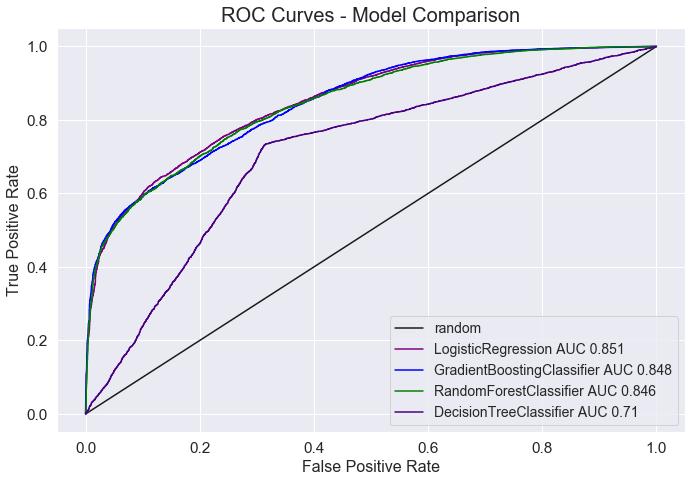

In [143]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('ROC Curves - Model Comparison', fontsize=20)

plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])
mods.plot_multiple_rocs(model_list, model2['review_text'], model2['skin_type'], TfidfVectorizer(), ax)
plt.tight_layout()
plt.savefig('imgs/model_compare_roc.png')

I will select the top 2 models and see how precision, accuracy, and recall compare for Logistic Regression and Gradient Boosting Classifier. It looks like the precision for Gradient Boosting Classifier is a little bit better, so this is the model I will settle on.

In addition, this model will help highlight feature importances of the text within the reviews and may give more insight into topics customers view as important.

In [224]:
logistic_model = mods.modelling(model2['review_text'], model2['skin_type'], TfidfVectorizer(), LogisticRegression())
gb_model = mods.modelling(model2['review_text'], model2['skin_type'], TfidfVectorizer(), GradientBoostingClassifier())

In [225]:
print('Accuracy for Logistic Regression is : {:.2f}'.format(logistic_model[1]))
print('Precision for Logistic Regression is : {:.2f}'.format(logistic_model[0]))
print('Recall for Logistic Regression is : {:.2f}'.format(logistic_model[2]))

Accuracy for Logistic Regression is : 0.76
Precision for Logistic Regression is : 0.77
Recall for Logistic Regression is : 0.79


In [226]:
print('Accuracy for Gradient Boosting Classifier is : {:.2f}'.format(gb_model[1]))
print('Precision for Gradient Boosting Classifier is : {:.2f}'.format(gb_model[0]))
print('Recall for Gradient Boosting Classifier is : {:.2f}'.format(gb_model[2]))

Accuracy for Gradient Boosting Classifier is : 0.75
Precision for Gradient Boosting Classifier is : 0.75
Recall for Gradient Boosting Classifier is : 0.79


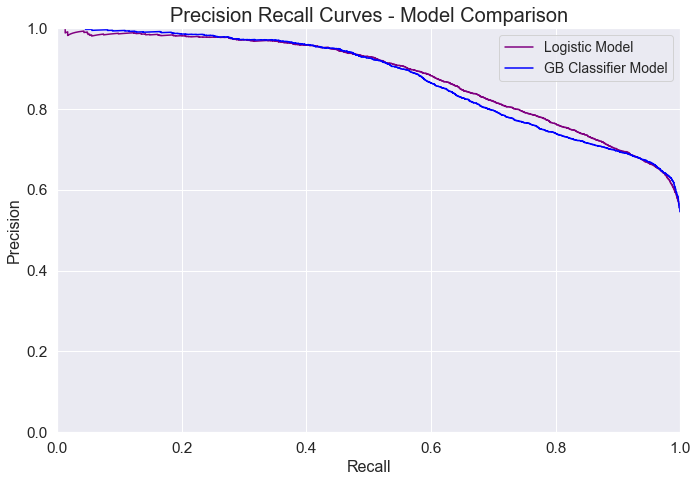

In [142]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Precision Recall Curves - Model Comparison', fontsize=20)

plt.gca().set_color_cycle(['purple', 'blue'])
# ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')


mods.plot_precision_recall(ax, logistic_model[3], 'Logistic Model')
mods.plot_precision_recall(ax, gb_model[3], 'GB Classifier Model')
plt.tight_layout()
plt.savefig('imgs/prec_recall.png')

In [124]:
# define EDA class
eda = EDA()

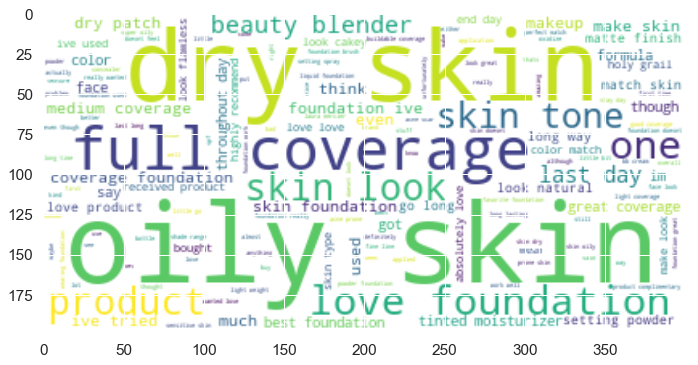

In [141]:
eda.create_wordcloud(model2, 'review_text')
plt.tight_layout()
plt.savefig('imgs/WordCloud_reviews.png')

In [145]:
word_freq = eda.w_freq(model2['review_text'])

word_lst = []
word_count = []
for row in word_freq:
    word_lst.append(row[0])
    word_count.append(row[1])

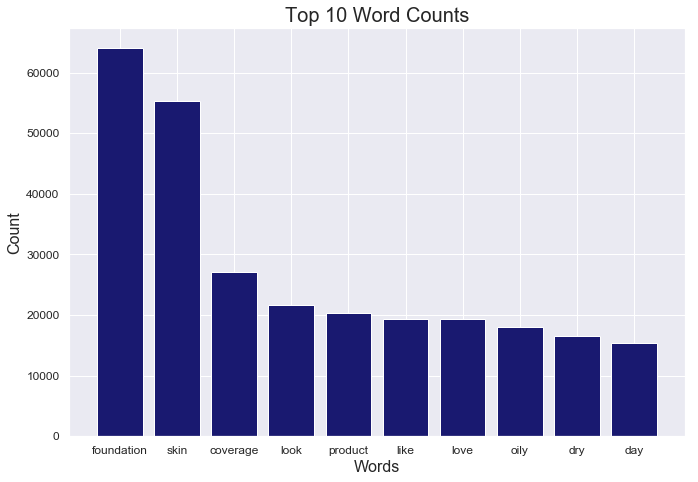

In [149]:
eda.top_10_word_freq(word_lst, word_count)
plt.tight_layout()
plt.savefig('imgs/top10_word_counts.png');

The words 'foundation' and 'skin' appear the most frequently. It's obvious that the dataset is on foundation, which is applied onto the skin, so it makes sense to exclude these and include these in the list of stopwords.

### Predicting dry/oily skin type based on review text removing words: 'foundation' and 'skin'.

In [8]:
model3 = df[['review_text', 'skin_type']].copy()
model3 = model3[(model3['skin_type'] == 'oily') | (model3['skin_type'] == 'dry')]
model3 = pre_process.oily_dry_skin(model3).reset_index(drop=True)

In [9]:
pre_process.format_strings(model3, 'review_text', WordNetLemmatizer())
model3.head()

,review_text,skin_type
0,really good like lot sometimes grab patch kind...,1
1,let say first need time apply practice make pe...,1
2,best ever used blotted mid day remained matte ...,1
3,arent many mainstream brand cater tone know pe...,1
4,best ever used get many compliment light weigh...,1


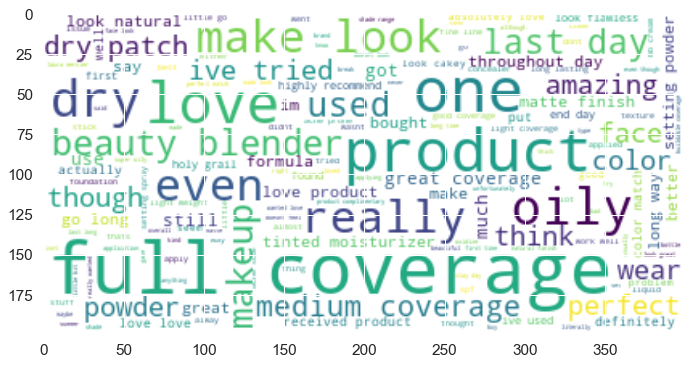

In [244]:
eda.create_wordcloud(model3, 'review_text')
plt.tight_layout()
plt.savefig('imgs/WordCloud_description3.png')

In [234]:
word_freq = eda.w_freq(model3['review_text'])

word_lst = []
word_count = []
for row in word_freq:
    word_lst.append(row[0])
    word_count.append(row[1])

What are the top 10 most frequent words after removing 'foundation' and 'skin'?

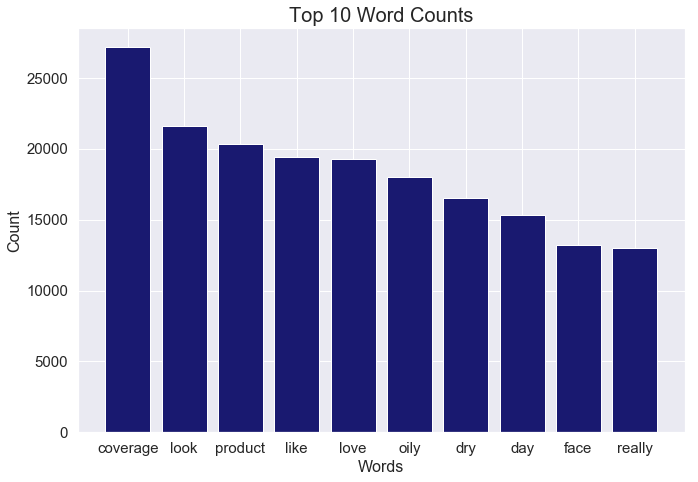

In [235]:
eda.top_10_word_freq(word_lst, word_count)
plt.tight_layout()
plt.savefig('imgs/top10_word_counts3.png');

In [236]:
gb = mods.modelling(model3['review_text'], model3['skin_type'], TfidfVectorizer(), GradientBoostingClassifier())

What do precision, accuracy, and recall for Gradient Boosting Classifier look like now that those 2 words have been removed? Scores are fairly the same, however, recall fell almost 10%. 

In [237]:
print('Accuracy for Gradient Boosting is : {:.2f}'.format(gb[1]))
print('Precision for Gradient Boosting is : {:.2f}'.format(gb[0]))
print('Recall for Gradient Boosting is : {:.2f}'.format(gb[2]))

Accuracy for Gradient Boosting is : 0.74
Precision for Gradient Boosting is : 0.82
Recall for Gradient Boosting is : 0.66


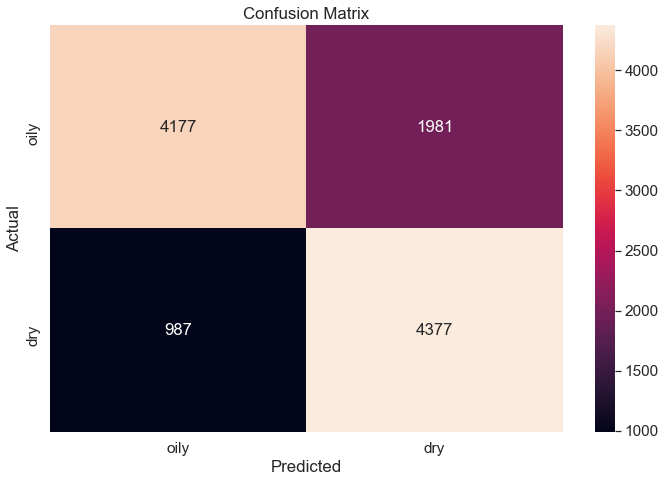

In [210]:
mods.get_conf_matrix()
plt.tight_layout()
plt.savefig('imgs/confusion_matrix_model3.png')

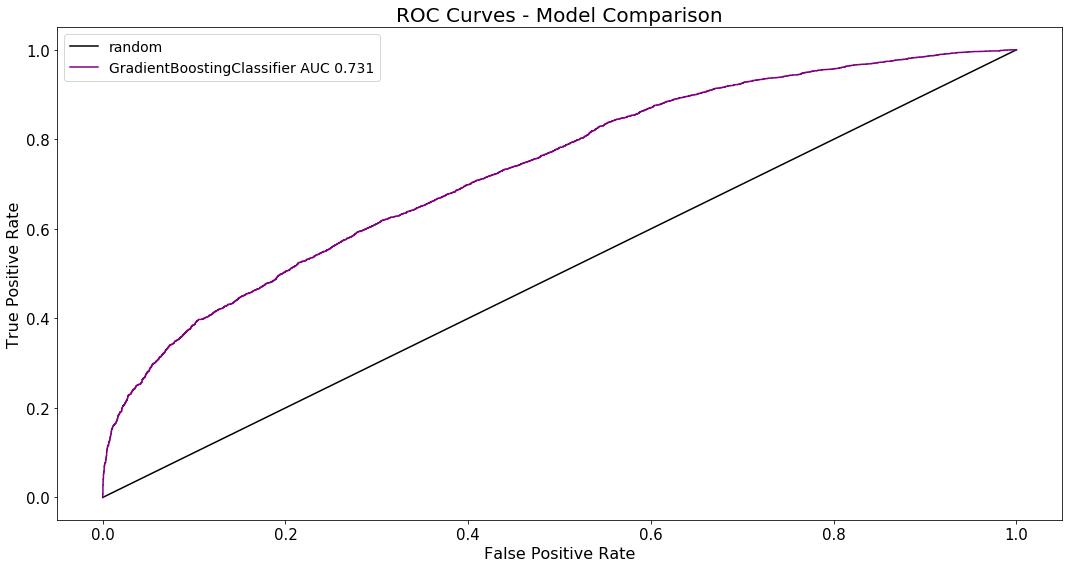

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('ROC Curves - Model Comparison', fontsize=20)

plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])
mods.plot_multiple_rocs([GradientBoostingClassifier()], model3['review_text'], model3['skin_type'], TfidfVectorizer(),ax)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('imgs/model_compare_roc3.png')

In [238]:
feature_importances = pd.DataFrame({'feature importance': gb[5].feature_importances_})
feature_importances['word'] = gb[6]
feature_importances.sort_values(by=['feature importance'], ascending=True, inplace=True)

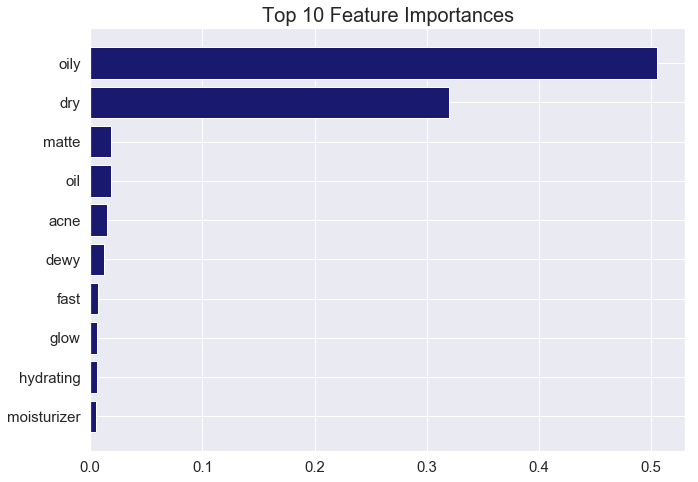

In [239]:
fig, ax = plt.subplots(figsize=(10,7))
plt.barh(feature_importances['word'][-10:], feature_importances['feature importance'][-10:], color='midnightblue')
plt.title('Top 10 Feature Importances', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

plt.tight_layout()
plt.savefig('imgs/top_10_feature_importances.png');

The words 'oily' and 'dry' are the 2 features that are the most important features in predicting if a user has oily or dry skin. This seems instinctual, but I'm curious to see what other features are important and how the model performs after removing these words. 

### Predicting dry/oily skin type based on review text removing words: 'foundation', 'skin', 'oily', and 'dry'.

In [262]:
model4 = df[['review_text', 'skin_type']].copy()
model4 = model4[(model4['skin_type'] == 'oily') | (model4['skin_type'] == 'dry')]
model4 = pre_process.oily_dry_skin(model4).reset_index(drop=True)

In [264]:
pre_process.format_strings(model4, 'review_text', WordNetLemmatizer())
model4.head()

,review_text,skin_type
0,really good like lot sometimes grab patch kind...,1
1,let say first need time apply practice make pe...,1
2,best ever used blotted mid day remained matte ...,1
3,arent many mainstream brand cater tone know pe...,1
4,best ever used get many compliment light weigh...,1


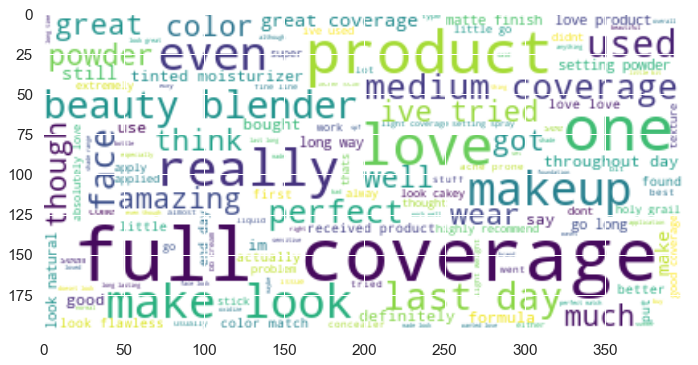

In [265]:
eda.create_wordcloud(model4, 'review_text')
plt.tight_layout()
plt.savefig('imgs/WordCloud_description4.png')

In [266]:
word_freq = eda.w_freq(model4['review_text'])

word_lst = []
word_count = []
for row in word_freq:
    word_lst.append(row[0])
    word_count.append(row[1])

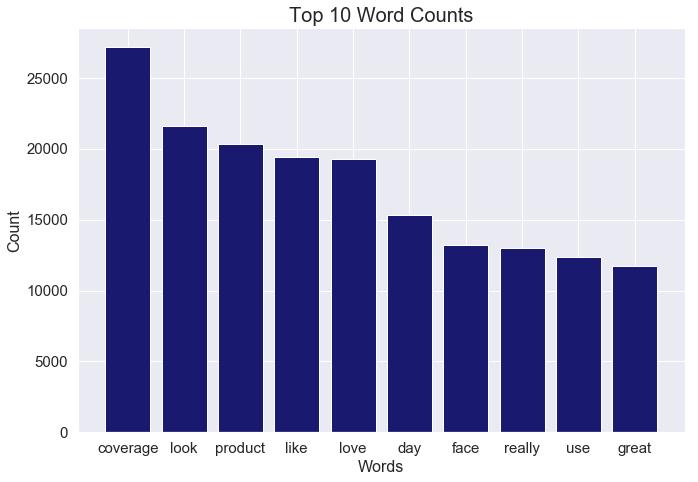

In [267]:
eda.top_10_word_freq(word_lst, word_count)
plt.tight_layout()
plt.savefig('imgs/top10_word_counts4.png');

In [268]:
gb2 = mods.modelling(model4['review_text'], model4['skin_type'], TfidfVectorizer(), GradientBoostingClassifier())

Accuracy and precision drop significantly, but recall improves by 15%! For my model, apart from accuracy, I'm also concerned with the recall score. It is important to minimize false negative values because it is detrimental to provide users with products that causes more oily skin.

However, I will stick with my previous model as my base model because of the drop in accuracy and precision.

In [270]:
print('Accuracy for Gradient Boosting is : {:.2f}'.format(gb2[1]))
print('Precision for Gradient Boosting is : {:.2f}'.format(gb2[0]))
print('Recall for Gradient Boosting is : {:.2f}'.format(gb2[2]))

Accuracy for Gradient Boosting is : 0.65
Precision for Gradient Boosting is : 0.64
Recall for Gradient Boosting is : 0.81


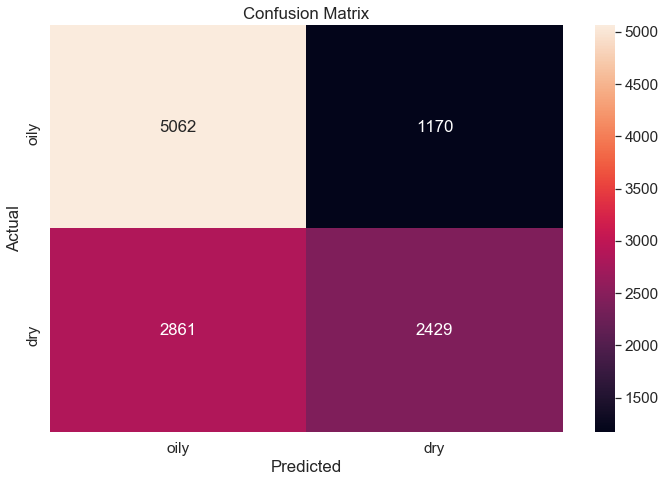

In [271]:
mods.get_conf_matrix()
plt.tight_layout()
plt.savefig('imgs/confusion_matrix_model4.png')

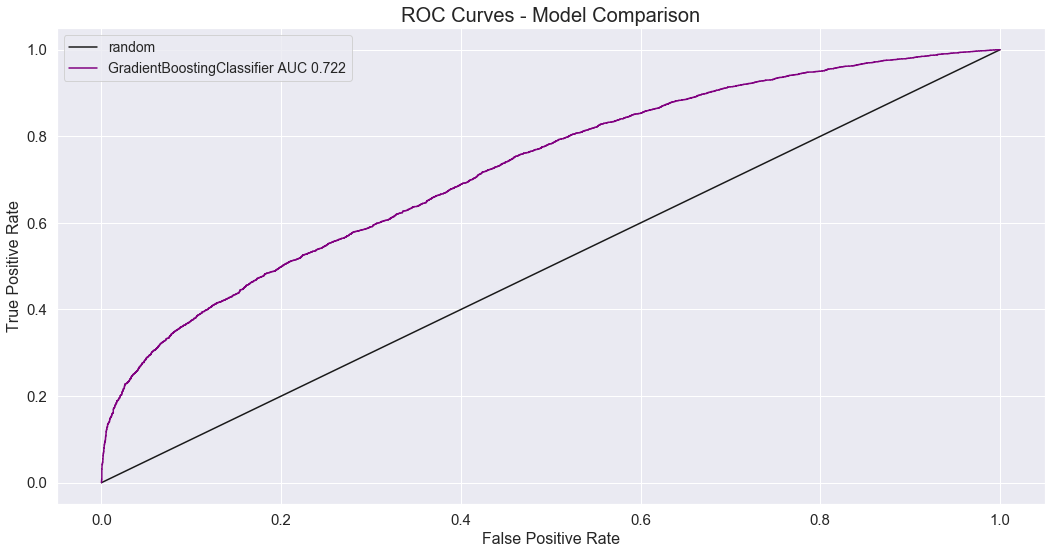

In [272]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('ROC Curves - Model Comparison', fontsize=20)

plt.gca().set_color_cycle(['purple', 'blue', 'green', 'indigo'])
mods.plot_multiple_rocs([GradientBoostingClassifier()], model4['review_text'], model4['skin_type'], TfidfVectorizer(),ax)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
# plt.savefig('imgs/model_compare_roc3.png')

In [273]:
feature_importances = pd.DataFrame({'feature importance': gb2[5].feature_importances_})
feature_importances['word'] = gb2[6]
feature_importances.sort_values(by=['feature importance'], ascending=True, inplace=True)

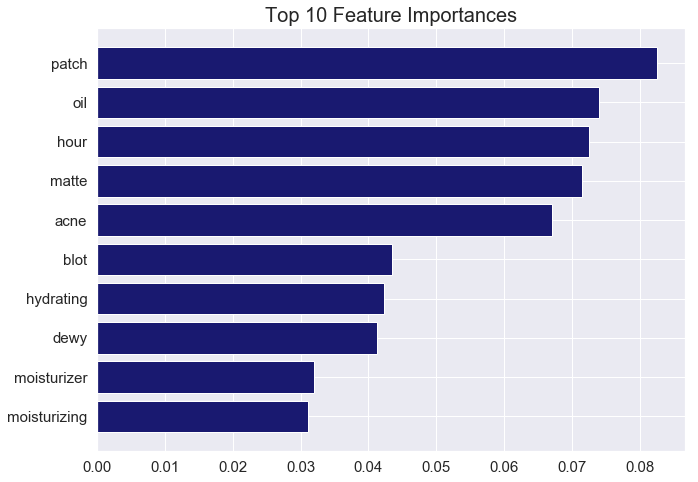

In [275]:
fig, ax = plt.subplots(figsize=(10,7))
plt.barh(feature_importances['word'][-10:], feature_importances['feature importance'][-10:], color='midnightblue')
plt.title('Top 10 Feature Importances', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

plt.tight_layout()
plt.savefig('imgs/top_10_feature_importances2.png');